# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

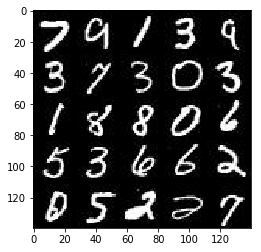

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

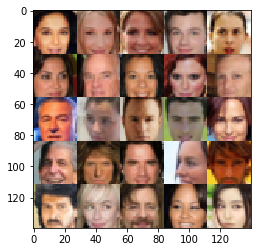

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name='real_images_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return real_images_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv_layer_1 = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu_1 = tf.maximum(alpha * conv_layer_1, conv_layer_1)
        
        print ('L1:',lrelu_1.shape)
        
        conv_layer_2 = tf.layers.conv2d(lrelu_1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        print ('L2:',lrelu_2.shape)
        
        conv_layer_3 = tf.layers.conv2d(lrelu_2, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm_3 = tf.layers.batch_normalization(conv_layer_3, training=True)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        print ('L3:',lrelu_3.shape)
        
        flattened = tf.reshape(lrelu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train==True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        
        
        fully_connected_1 = tf.layers.dense(z, 7*7*512)
        reshaped_1 = tf.reshape(fully_connected_1, (-1, 7, 7, 512))
        batch_norm_1 = tf.layers.batch_normalization(reshaped_1, training=is_train)
        lrelu_1 = tf.maximum(alpha *batch_norm_1, batch_norm_1)
        
        print ('L1:',lrelu_1.shape)
        
        deconv_2 = tf.layers.conv2d_transpose(lrelu_1, 256, 5, strides=1, padding='same')
        batch_norm_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
    
        print ('DL2:',lrelu_2.shape)
        
        deconv_3 = tf.layers.conv2d_transpose(lrelu_2, 128, 5, strides=2, padding='same')
        batch_norm_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        print ('DL3:',lrelu_3.shape)
        
        logits = tf.layers.conv2d_transpose(lrelu_3, out_channel_dim, 5, strides=2, padding='same')
       
        print ('Output:',logits.shape)
        
        output = tf.tanh(logits) 
        
        return output
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 5)
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_real_output, d_real_logits = discriminator(input_real)
    d_fake_output, d_fake_logits = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,
                                                labels=tf.ones_like(d_real_logits)*alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 4)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    real_input, z_input, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 14.4925
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.8429
Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 4.2309
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 2.9840
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 2.4168
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 2.0069
Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.6905... Generator Loss: 2.7735
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


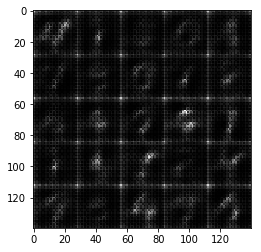

Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.4785
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 1.4301
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 1.8817
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


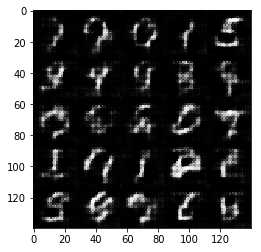

Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.8501
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 1.9965
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 1.0582
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


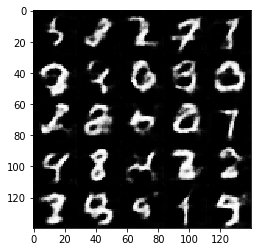

Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 1.2846
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.3579
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.5652
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 1.8375
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


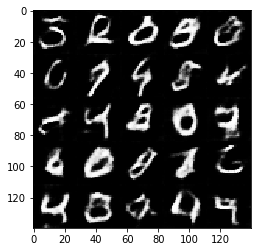

Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 2.1078... Generator Loss: 2.6891
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 1.4957
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.9583
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


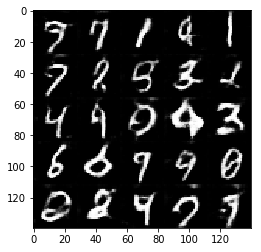

Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.9355... Generator Loss: 2.8044
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.4276
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.8675
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


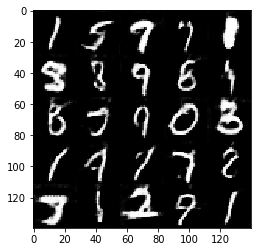

Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 1.1861
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 1.5713
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 1.1753
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


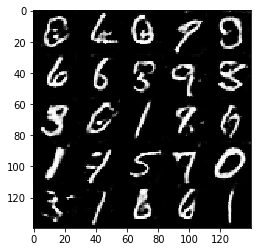

Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 1.7299
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.7578... Generator Loss: 1.9700
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.5462
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


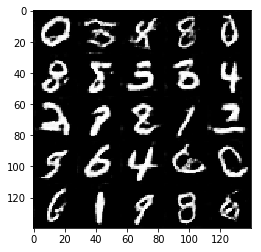

Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 1.5752... Generator Loss: 0.4222
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.4971
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.4990
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.8702
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 1)


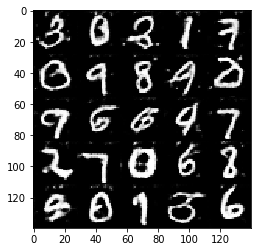

Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.6896


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
L1: (?, 14, 14, 64)
L2: (?, 7, 7, 128)
L3: (?, 4, 4, 256)
Epoch 1/1... Discriminator Loss: 2.2483... Generator Loss: 0.2160
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.8426
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 4.2077
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 2.4209
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 4.2811
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 6.2124
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 2.4493
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.5912
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


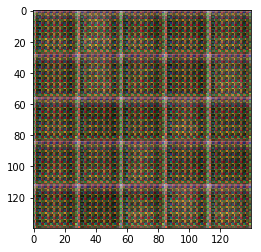

Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 2.0577
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 3.9223
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 2.0103
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.5562
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


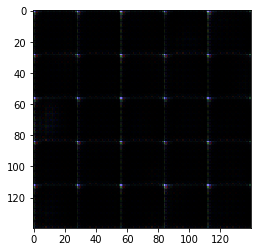

Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.1312
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


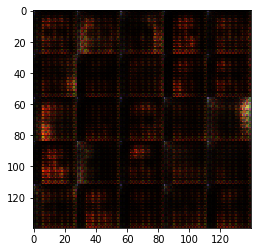

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 1.6605
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6958
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


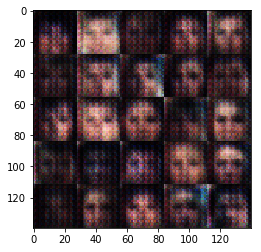

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.9648
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.2439
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


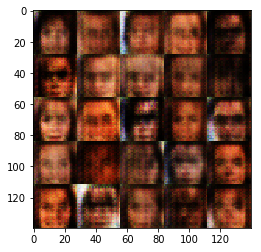

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.2161
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


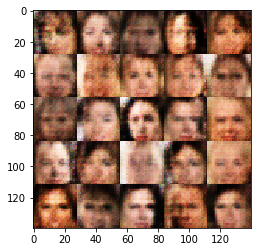

Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 2.1171... Generator Loss: 0.2246
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.3655
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


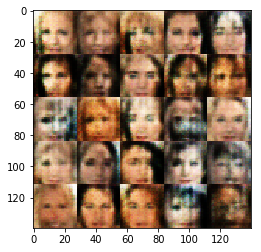

Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.9305
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.2275
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


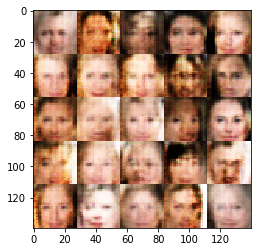

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.7103
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 2.9977
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.7789
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


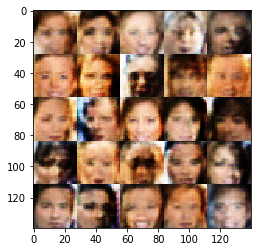

Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 2.6284
Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 2.1713
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.2668
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


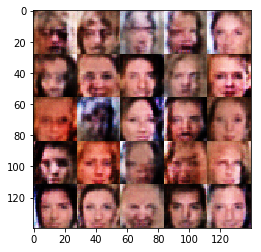

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 2.5104
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7179
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


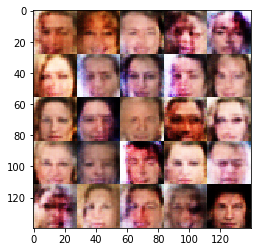

Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 2.2669
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 2.1389
Epoch 1/1... Discriminator Loss: 1.9039... Generator Loss: 1.9209
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.3110
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


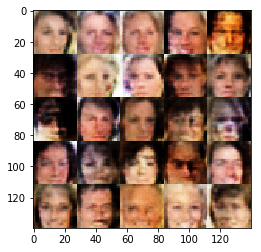

Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 3.2644
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 2.9176
Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5462
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


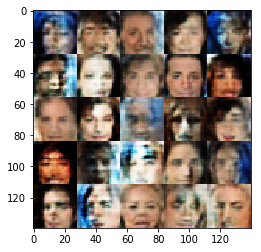

Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 2.3347
Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 3.6383
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.7984... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 2.0883
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.3728
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


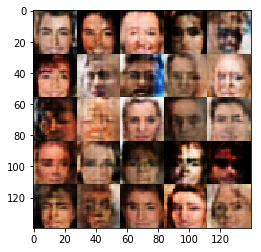

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.7347... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 2.0346
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.7493
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4123
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


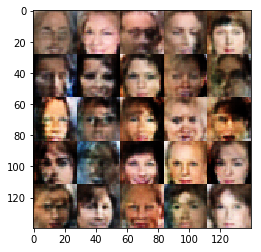

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.6611... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.0598
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


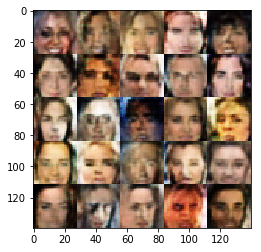

Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.9548... Generator Loss: 0.2474
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 2.5275
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7956
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


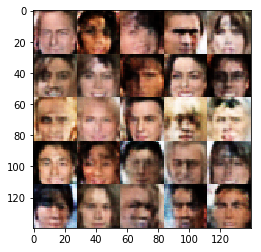

Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 2.0894
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 1.9414
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 2.0307... Generator Loss: 0.2387
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.0234
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


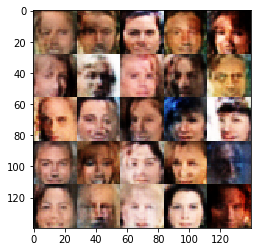

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 2.4718
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 2.0537... Generator Loss: 0.2326
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 1.3573
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


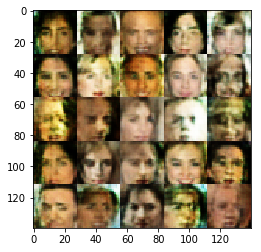

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 2.1767
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8215
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


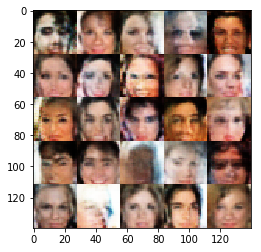

Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.6205
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


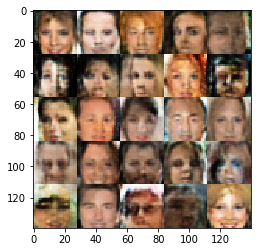

Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 2.8242
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 1.9352
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.7604
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


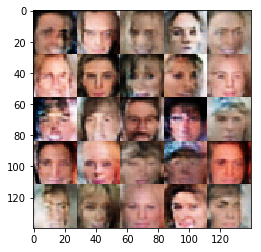

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 2.2987
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 3.1835
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 2.1710
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7583
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


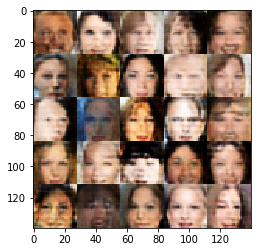

Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 2.1980
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


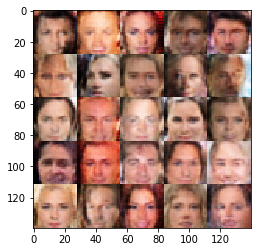

Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.8791... Generator Loss: 0.2843
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 1.7976... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 2.2523
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


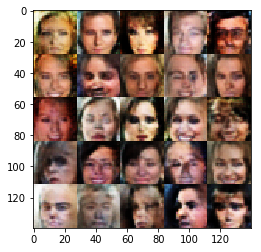

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 2.0765
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 2.3481
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5451
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


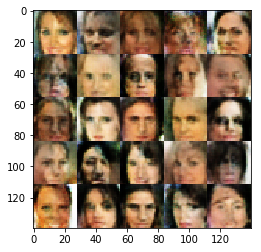

Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.8085
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8992
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


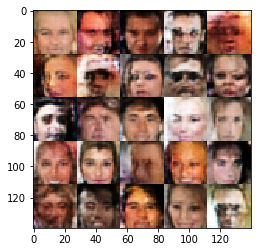

Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6988
L1: (?, 7, 7, 512)
DL2: (?, 7, 7, 256)
DL3: (?, 14, 14, 128)
Output: (?, 28, 28, 3)


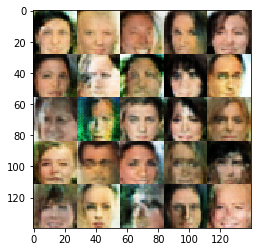

Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.3507
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 2.0569
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0378


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.